In [4]:
import json
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

all_listings = json.loads(pathlib.Path('./all_listings.json').read_text())
df = pd.DataFrame(all_listings)
df.date_listed = pd.to_datetime(df.date_listed)

In [5]:
CENTRAL_BUREAU_OF_STATISTICS_EXCEL_URL = 'https://www.cbs.gov.il/he/publications/LochutTlushim/2020/%D7%90%D7%95%D7%9B%D7%9C%D7%95%D7%A1%D7%99%D7%99%D7%942020.xlsx'
city_names_and_populations = pd.read_excel(CENTRAL_BUREAU_OF_STATISTICS_EXCEL_URL,
                                           usecols='B,G,H', keep_default_na=False, skipfooter=7, header=7, sheet_name=0)
city_names_and_populations = city_names_and_populations.set_axis(['hebrew_city', 'city_population', 'english_city'], axis=1)
city_names_and_populations.city_population = city_names_and_populations.city_population.astype(int)

In [6]:
# fix specific cities to match
TYPOS = {
    'תל אביב -יפו': 'תל אביב יפו',
    'הרצלייה': 'הרצליה',
    'קדימה-צורן': 'קדימה צורן',
    'מודיעין-מכבים-רעות*': 'מודיעין מכבים רעות',
    'קריית אונו': 'קרית אונו',
    'יהוד-מונוסון': 'יהוד מונוסון',
    'קריית גת': 'קרית גת',
    'קריית מלאכי': 'קרית מלאכי',
    'קריית עקרון': 'קרית עקרון',
    'גבע בנימין': 'אדם - גבע בנימין',
    'בית אריה-עופרים': 'בית אריה / עופרים',
    'נהרייה': 'נהריה',
    'קריית מוצקין': 'קרית מוצקין',
    'קריית אתא': 'קרית אתא',
    'קריית ביאליק': 'קרית ביאליק',
    'קריית ים': 'קרית ים',
    'פרדס חנה-כרכור': 'פרדס חנה כרכור',
    'נוף הגליל': 'נצרת עילית / נוף הגליל',
    'קריית שמונה': 'קרית שמונה',
    'מעלות-תרשיחא': 'מעלות תרשיחא',
    'קריית טבעון': 'קרית טבעון',
    'בנימינה-גבעת עדה*': 'בנימינה גבעת עדה',
    'מיתר': 'מיתר / כרמית',
    'כוכב יאיר': 'כוכב יאיר / צור יגאל',
    'סביון*': 'סביון',
    'פרדסייה': 'פרדסיה',
    'שער שומרון': 'שערי תקווה',
    'קריית ארבע': 'קרית ארבע',
    'בית יצחק-שער חפר': 'בית יצחק שער חפר',
}

city_names_and_populations = city_names_and_populations.replace(TYPOS)

In [7]:
df = df.merge(city_names_and_populations, left_on='city', right_on='hebrew_city', how='left')
# df = df.drop('city', axis=1)
# from what I saw about 1% of listings are in cities with a population of less than 2000,
# for simplicity we'll ignore them
df = df.dropna()
df.city_population = df.city_population.astype(int)

In [8]:
x = df[df.english_city.isnull()].city.value_counts()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(x[x>5])

Series([], Name: city, dtype: int64)


In [9]:
# CITIES_BLACKLIST = {'רמלה', 'לוד', 'אלעד', 'נתניה', 'כפר יונה', 'צור יצחק', 'גדרה', 'קרית עקרון', 'אשדוד', 'אשקלון', 'קרית גת', 'קרית מלאכי',
#                     'שדרות', 'בני עי"ש', 'ביתר עילית', 'אדם - גבע בנימין', 'עמנואל', 'גבעת זאב', 'עלי', 'קרני שומרון', 'אפרת', 'אבני חפץ', 'מודיעין עילית'}
CITIES_BLACKLIST = set()
MIN_AMOUNT_OF_LISTINGS_IN_CITY = 9

# drop erroneos extreme rows to clean data set
df = df[(df.area < df.area.mean() * 5) & (df.area > df.area.mean() / 10)]
df = df[df.date_listed > (pd.Timestamp.today() - pd.Timedelta(16, unit='W'))]
listing_count_by_city = df.hebrew_city.value_counts()
# print(listing_count_by_city)
cities_to_ignore = CITIES_BLACKLIST | \
    set(listing_count_by_city.loc[lambda listing_count: listing_count < MIN_AMOUNT_OF_LISTINGS_IN_CITY].index)
df = df[~df.hebrew_city.isin(cities_to_ignore)]
df = df.reset_index(drop=True)
display(df)
df.describe()

,date_listed,city,neighborhood,street,coordinates,floor,rooms,area,price,for_sale,hebrew_city,city_population,english_city
0,2022-12-26 11:31:32,הוד השרון,מתחם 1200,גולדה מאיר,"{'latitude': 32.165478, 'longitude': 34.898991}",4,4,134,4190000,True,הוד השרון,65716,Hod HaSharon
1,2022-10-29 10:52:25,הוד השרון,מגדיאל,טרומפלדור,"{'latitude': 32.161737, 'longitude': 34.904687}",4,4,105,3200000,True,הוד השרון,65716,Hod HaSharon
2,2022-11-06 19:34:05,נתניה,אגמים,שדרות האגמים,"{'latitude': 32.29103, 'longitude': 34.849886}",10,5,155,3820000,True,נתניה,231983,Netanya
3,2022-11-01 09:26:10,נתניה,אגמים,שדרות בן צבי,"{'latitude': 32.29227, 'longitude': 34.852649}",1,5,130,3195000,True,נתניה,231983,Netanya
4,2022-12-10 16:21:53,הרצליה,מרכז,שחרית,"{'latitude': 32.173116, 'longitude': 34.833835}",2,5,125,4640000,True,הרצליה,106423,Herzliyya
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34913,2022-11-16 13:24:47,עכו,נווה יוני נתניהו,שדליץ,"{'latitude': 32.925758, 'longitude': 35.091465}",0,4,120,5000,False,עכו,51103,Akko
34914,2022-10-21 10:52:44,חיפה,מרכז הכרמל,יצחק אלחנן,"{'latitude': 32.802898, 'longitude': 34.989809}",1,2,67,3550,False,חיפה,288543,Haifa
34915,2022-10-10 20:49:04,חיפה,מרכז הכרמל,כיכר היינריך היינה,"{'latitude': 32.797807, 'longitude': 34.983104}",1,2,65,3500,False,חיפה,288543,Haifa
34916,2022-11-16 08:49:06,טירת כרמל,גיורא,ש גיורא,"{'latitude': 32.754198, 'longitude': 34.969548}",1,3,72,2800,False,טירת כרמל,28626,Tirat Karmel


,floor,rooms,area,price,city_population
count,34918.000000,34918.000000,34918.000000,3.491800e+04,34918.000000
mean,3.225958,3.769574,117.999227,1.511644e+06,229821.058566
std,4.040623,1.271402,79.187909,1.932402e+06,235487.709598
min,-5.000000,0.000000,15.000000,1.000000e+03,2026.000000
25%,1.000000,3.000000,75.000000,4.600000e+03,61432.000000
50%,2.000000,4.000000,100.000000,7.750000e+05,171810.000000
75%,4.000000,4.000000,130.000000,2.600000e+06,259811.000000
max,60.000000,12.000000,743.000000,1.200000e+07,978036.000000


In [10]:
df[df.for_sale == False]
_, area_bins1 = pd.qcut(df[df.english_city == 'Netanya'].area, 10, retbins=True)
_, area_bins2 = pd.qcut(df[df.english_city == 'Petah Tiqwa'].area, 10, retbins=True)
display(area_bins1)
display(area_bins2)

array([ 18. ,  60. ,  75. ,  90. , 103. , 115. , 125. , 136. , 150.6,
       208.2, 650. ])

array([ 20.,  65.,  78.,  90.,  95., 100., 112., 120., 135., 160., 630.])

In [11]:
CITIES = {
    'מרכז': {
        'Tel Aviv - Yafo', 'Petah Tiqwa', 'Giv\'atayim', 'Be\'er Ya\'aqov', 'Qiryat Ono', 'Ramla',
        'Bene Beraq', 'Rosh HaAyin', 'El\'ad', 'Or Yehuda', 'Ganne Tiqwa', 'Bat Yam', 'Lod',
        'Ramat Gan', 'Modi\'in-Makkabbim-Re\'ut', 'Rishon LeZiyyon', 'Giv\'at Shemu\'el',
        'Yehud-Monoson', 'Holon', 'Azor', 'Bet Dagan', 'Ramat HaSharon', 'Shoham'
    },
    'שרון': {
        'Ra\'annana', 'Qadima- Zoran', 'Herzliyya', 'Hod HaSharon', 'Tel Mond', 'Kefar Sava',
        'Kefar Yona', 'Netanya', 'Even Yehuda', 'Bat Hefer', 'Bet Yizhaq-Sh. Hefer', 'Elyakhin',
        'Kokhav Ya\'ir', 'Mattan', 'Pardesiyya'
    },
    'יהודה ושומרון ובקעת הירדן': {
        'Alfe Menashe', 'Ari\'el', 'Giv\'at Ze\'ev', 'Immanu\'el', 'Eli', 'Qarne Shomeron',
        'Zur Yizhaq', 'Betar Illit', 'Avne Hefez', 'Geva Binyamin', 'Efrat', 'Modi\'in Illit',
        'Ale Zahav', 'Bet Arye-Ofarim', 'Bet El', 'Ganne Modi\'in', 'Har Adar', 'Kefar Adummim',
        'Kokhav Ya\'aqov', 'Na\'ale', 'Allon Shevut', 'Barqan', 'Brukhin', 'El\'azar', 'Elon More',
        'Elqana', 'Mizpe Yeriho', 'Nili', 'Noqedim', 'Ofra', 'Oranit', 'Qedumim', 'Qiryat Arba',
        'Revava', 'Sha\'ar Shomron', 'Talmon'
    },
    'חדרה, זכרון והעמקים': {
        'Ramat Yishay', 'Afula', 'Yoqne\'am Illit', 'Rekhasim', 'Bet She\'an',
        'Binyamina-Giv\'at Ada', 'Pardes Hanna-Karkur', 'Qiryat Tiv\'on', 'Zikhron Ya\'aqov',
        'Hadera', 'Or Aqiva', 'Harish', 'Qesaryya', 'Atlit', 'Isifya', 'Ahuzzat Baraq', 'Qazir'
    },
    'מחוז ירושלים': {
        'Zur Hadassa', 'Bet Shemesh', 'Ma\'ale Adummim', 'Mevasseret Ziyyon', 'Jerusalem',
        'Abu Ghosh'
    },
    'שפלה ומישור החוף הדרומי': {
        'Qiryat Gat', 'Ashdod', 'Sederot', 'Rehovot', 'Qiryat Mal\'akhi', 'Qiryat Eqron',
        'Bene Ayish', 'Gedera', 'Yavne', 'Ashqelon', 'Nes Ziyyona', 'Gan Yavne', 'Mazkeret Batya',
        'Be\'er Gannim', 'Merkaz Shappira', 'Shetulim', 'Yad Binyamin'
    },
    'דרום': {
        'Dimona', 'Elat', 'Metar', 'Be\'er Sheva', 'Lehavim', 'Yeroham', 'Ofaqim', 'Mizpe Ramon',
        'Arad', 'Netivot', 'Omer'
    },
    'צפון': {
        'Qiryat Bialik', 'Tiberias', 'Qiryat Yam', 'Nesher', 'Migdal', 'Akko', 'Shelomi', 'Qazrin',
        'Zefat', 'Migdal HaEmeq', 'Ma\'alot-Tarshiha', 'Karmi\'el', 'Qiryat Atta', 'Qiryat Shemona',
        'Tirat Karmel', 'Haifa', 'Yavne\'el', 'Nahariyya', 'Nof HaGalil', 'Qiryat Motzkin',
        'Hazor HaGelilit', 'Kefar Weradim', 'Nazareth', 'Kefar Tavor', 'Nofit', 'Rosh Pinna'
    }
}


In [12]:
set(df.english_city.unique()) - {city for area in CITIES for city in CITIES[area]}

set()

english_city         area_bin         price                      \
                                                    mean               count   
for_sale                                           False          True False   
0           Be'er Ya'aqov  (51.999, 100.0]   4929.166667  2.649286e+06    12   
1           Be'er Ya'aqov   (100.0, 104.0]   6200.000000  2.866364e+06     6   
2           Be'er Ya'aqov   (104.0, 107.5]   4700.000000  2.875833e+06     1   
3           Be'er Ya'aqov   (107.5, 118.0]   6480.000000  2.942941e+06     5   
4           Be'er Ya'aqov   (118.0, 120.0]   6792.857143  3.210000e+06     7   
5           Be'er Ya'aqov   (120.0, 125.0]   6723.900000  3.248929e+06    10   
6           Be'er Ya'aqov   (125.0, 130.0]   7106.250000  3.302500e+06     8   
7           Be'er Ya'aqov   (130.0, 137.0]   6548.000000  3.319900e+06     5   
8           Be'er Ya'aqov   (137.0, 210.0]   7850.000000  4.018571e+06     6   
9           Be'er Ya'aqov   (210.0, 680.0]   8577.750000  5.940769e+06     4   
10             Giv'atayim   (17.999, 65.0]   4711.111111  2.412812e+06    27   
11             Giv'atayim     (65.0, 75.0]   6481.250000  2.949500e+06    24   
12             Giv'atayim     (75.0, 85.0]   6295.476190  3.369167e+06    21   
13             Giv'atayim     (85.0, 94.0]   6962.500000  3.554357e+06    16   
14             Giv'atayim    (94.0, 101.0]   6882.352941  3.649886e+06    17   
15             Giv'atayim   (101.0, 108.2]   7853.333333  4.071304e+06    15   
16             Giv'atayim   (108.2, 119.4]   7576.923077  4.442115e+06    13   
17             Giv'atayim   (119.4, 130.6]   9099.863636  4.681471e+06    22   
18             Giv'atayim   (130.6, 146.0]   9966.666667  4.756029e+06     6   
19             Giv'atayim   (146.0, 350.0]   9780.000000  7.189155e+06    10   
20            Petah Tiqwa   (19.999, 65.0]   3619.935897  1.736182e+06    78   
21            Petah Tiqwa     (65.0, 78.0]   4546.969697  1.998680e+06    33   
22            Petah Tiqwa     (78.0, 90.0]   5026.851852  2.262816e+06    54   
23            Petah Tiqwa     (90.0, 95.0]   5260.642857  2.446265e+06    14   
24            Petah Tiqwa    (95.0, 100.0]   5693.103448  2.512000e+06    29   
25            Petah Tiqwa   (100.0, 112.0]   6290.384615  2.679474e+06    26   
26            Petah Tiqwa   (112.0, 120.0]   6319.117647  2.999851e+06    34   
27            Petah Tiqwa   (120.0, 135.0]   7131.250000  3.322500e+06    32   
28            Petah Tiqwa   (135.0, 160.0]   8236.486486  3.750867e+06    37   
29            Petah Tiqwa   (160.0, 630.0]  11355.518519  4.289356e+06    27   
30             Qiryat Ono   (29.999, 78.4]   4275.000000  2.342500e+06    12   
31             Qiryat Ono     (78.4, 94.2]   5100.000000  2.793333e+06     6   
32             Qiryat Ono    (94.2, 105.0]   6425.000000  2.779000e+06     6   
33             Qiryat Ono   (105.0, 113.0]   6642.714286  3.420625e+06     7   
34             Qiryat Ono   (113.0, 120.5]   7150.000000  3.513333e+06     5   
35             Qiryat Ono   (120.5, 130.0]   7255.833333  3.701667e+06    12   
36             Qiryat Ono   (130.0, 137.0]   7500.000000  3.827500e+06     3   
37             Qiryat Ono   (137.0, 150.0]   7800.000000  4.425000e+06     8   
38             Qiryat Ono   (150.0, 247.0]   9962.500000  5.701667e+06     8   
39             Qiryat Ono   (247.0, 480.0]   9000.000000  7.202143e+06     2   
40        Tel Aviv - Yafo   (14.999, 46.8]   4511.298551  2.284383e+06   345   
41        Tel Aviv - Yafo     (46.8, 60.0]   6169.574627  3.018565e+06   268   
42        Tel Aviv - Yafo     (60.0, 70.0]   7458.189441  3.783951e+06   322   
43        Tel Aviv - Yafo     (70.0, 78.0]   7776.598684  4.152251e+06   152   
44        Tel Aviv - Yafo     (78.0, 85.0]   9050.504310  4.316587e+06   232   
45        Tel Aviv - Yafo     (85.0, 97.0]   9252.802885  4.394911e+06   208   
46        Tel Aviv - Yafo    (97.0, 106.6]  10182.391304  4.897264e+06   207   
47        Tel

Text(0.5, 1.0, 'Annual Yield From Rent')

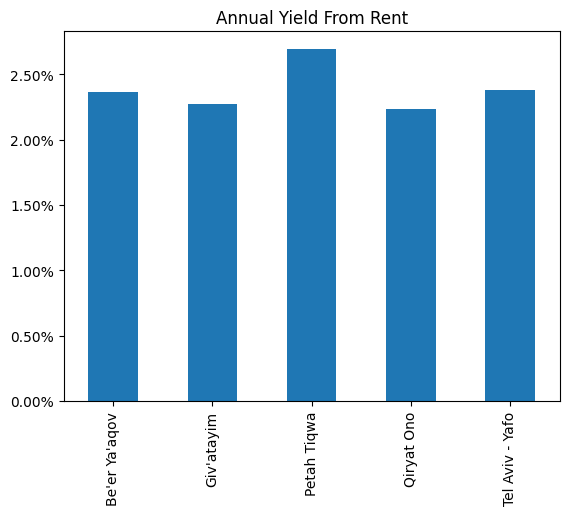

In [25]:
import matplotlib.ticker as mtick
import numpy as np
df1 = df[df.english_city.isin(['Petah Tiqwa', 'Qiryat Ono'])]
MIN_IN_EACH_BIN = 3
MAX_AMOUNT_OF_BINS = 10
dfs = list()
for city in df1.english_city.unique():
    x = df[df.english_city == city]
    number_of_bins = min(MAX_AMOUNT_OF_BINS, int(x.shape[0] / MIN_IN_EACH_BIN))
    dfs.append(x.assign(area_bin=pd.qcut(x.area, number_of_bins, duplicates='drop')))
    
x = pd.concat(dfs).groupby(['english_city', 'area_bin', 'for_sale'])\
    .agg({'price': ['mean', 'count']}).unstack().reset_index()
display(x)
res =  x.groupby('english_city').apply(
    lambda x: np.average(x['price']['mean'][False] * 12 / x['price']['mean'][True],
                         weights=x['price']['count'][False] + x['price']['count'][True]))
plot = res.plot.bar()
plot.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plot.set_xlabel(None)
plot.set_title('Annual Yield From Rent')
# x = x.group

Text(0.5, 1.0, 'Distribution of the Area of Listings')

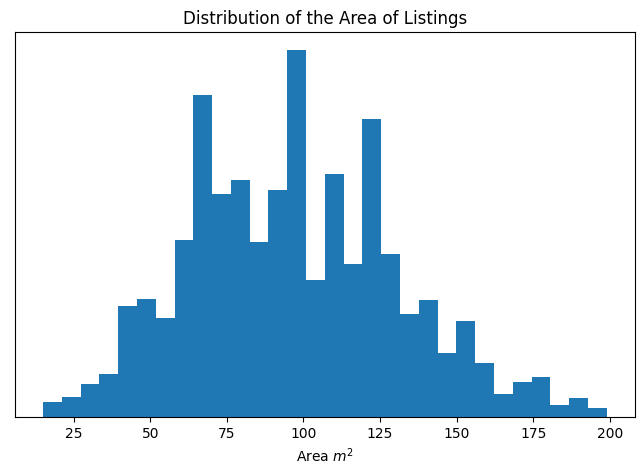

In [13]:
plot = df[df.area < 200].area.hist(bins=30, figsize=(8, 5), grid=False)
plot.get_yaxis().set_visible(False)
plot.set_xlabel('Area $m^2$')
plot.set_title('Distribution of the Area of Listings')

Text(0.5, 1.0, 'Distribution of Prices')

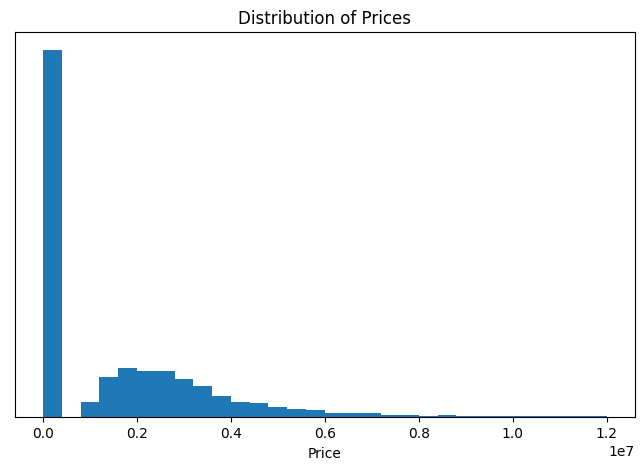

In [8]:
plot = df.price.hist(bins=30, figsize=(8, 5), grid=False)
plot.get_yaxis().set_visible(False)
plot.set_xlabel('Price')
plot.set_title('Distribution of Prices')

Text(0.5, 1.0, 'Distribution of Dates Listed')

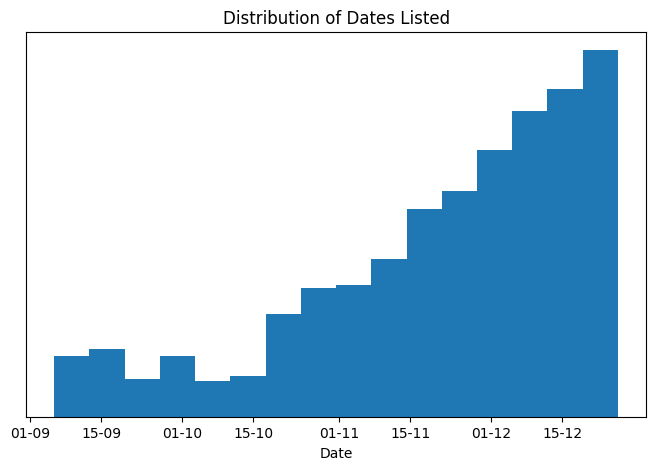

In [9]:
import matplotlib

plot = df.date_listed.hist(bins=16, figsize=(8, 5), grid=False)
plot.get_yaxis().set_visible(False)
plot.set_xlabel('Date')
plot.get_xaxis().set_major_formatter(matplotlib.dates.DateFormatter('%d-%m'))
plot.set_title('Distribution of Dates Listed')

Text(0.5, 1.0, 'Day of the Week Listed')

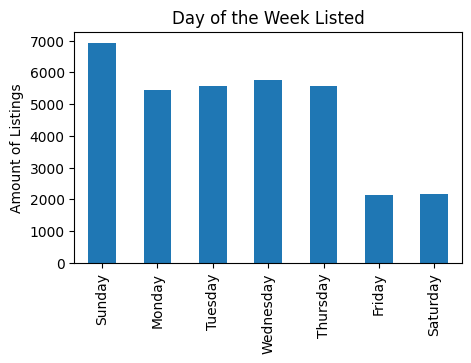

In [10]:
import calendar

WEEKDAYS = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plot = pd.Series([calendar.day_name[date.weekday()] for date in df.date_listed]).value_counts().\
    sort_index(key=lambda day_names: [WEEKDAYS.index(day_name) for day_name in day_names]).plot.bar(figsize=(5,3))
plot.set_ylabel('Amount of Listings')
plot.set_title('Day of the Week Listed')

Text(0.5, 1.0, 'Distribution of Number of Rooms')

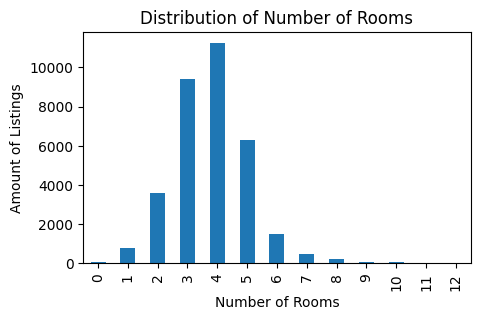

In [11]:
plot = df.rooms.value_counts().sort_index().plot.bar(figsize=(5,3))
plot.set_xlabel('Number of Rooms')
plot.set_ylabel('Amount of Listings')
plot.set_title('Distribution of Number of Rooms')

Text(0.5, 1.0, 'Time of Day Listings Were Posted')

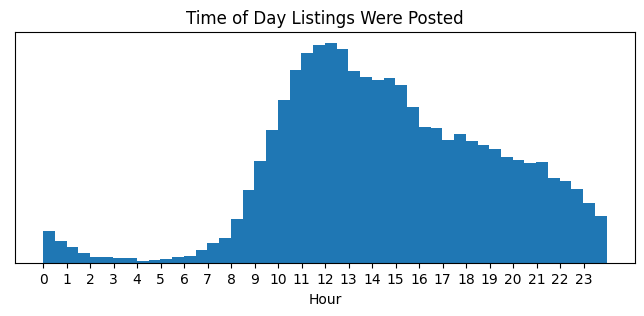

In [12]:
plot = pd.Series([date_listed.time().hour + date_listed.time().minute / 60 for date_listed in df.date_listed])\
    .hist(bins=48, figsize=(8, 3), grid=False)
plot.get_yaxis().set_visible(False)
plot.get_xaxis().set_ticks([i for i in range(0, 24, 1)])
plot.set_xlabel('Hour')
plot.set_title('Time of Day Listings Were Posted')

Text(0.5, 1.0, 'Distribution of Floor Number')

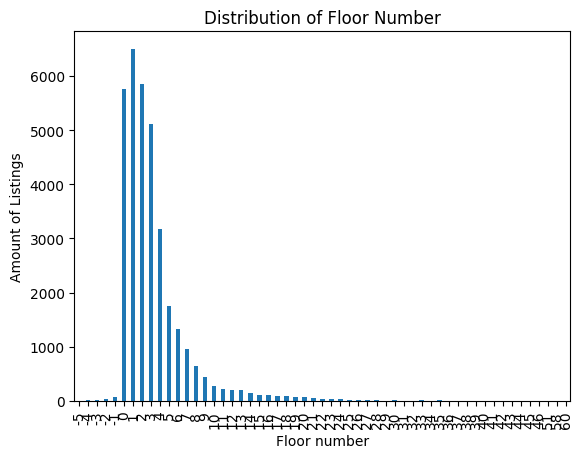

In [13]:
plot = df.floor.value_counts().sort_index().plot.bar()
plot.set_xlabel('Floor number')
plot.set_ylabel('Amount of Listings')
plot.set_title('Distribution of Floor Number')

Text(0.5, 1.0, 'Amount of Listings, and the Price per Square Meter, for each City')

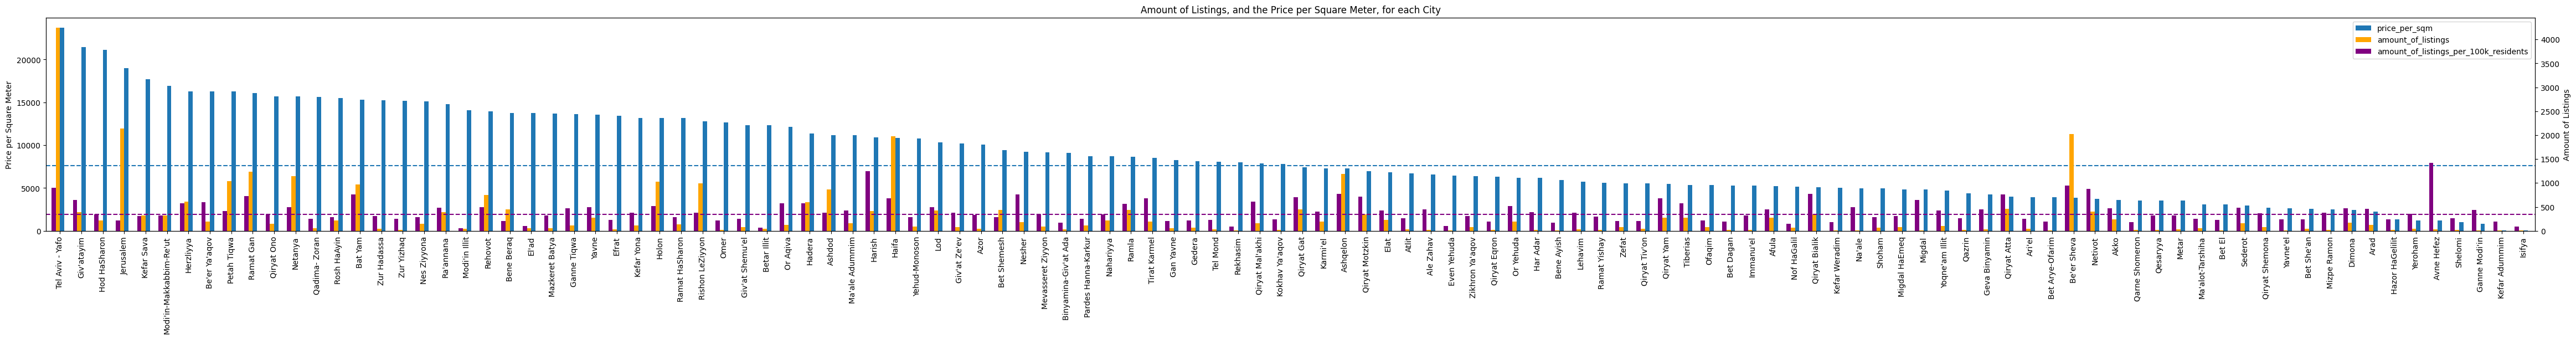

In [14]:
# create df
amount_of_listings = df.english_city.value_counts()
amount_of_listings.name = 'amount_of_listings'
df['price_per_sqm'] = df.price / df.area
prices_per_sqm = df.groupby('english_city').mean(numeric_only=True)['price_per_sqm'].sort_values(ascending=False).astype(int)
df = df.drop('price_per_sqm', axis=1)
cities_df = pd.merge(prices_per_sqm, amount_of_listings, left_index=True, right_index=True)
cities_df = cities_df.merge(city_names_and_populations, left_index=True, right_on='english_city')
cities_df = cities_df.set_index('english_city')
cities_df['amount_of_listings_per_100k_residents'] = ((cities_df.amount_of_listings / cities_df.city_population) * 100000).astype(int)
median_amount_of_listings_per_100k_residents = cities_df.amount_of_listings_per_100k_residents.median()
median_price_per_sqm = cities_df.price_per_sqm.median()

# plotting
fig, ax = plt.subplots()
ax2 = ax.twinx()
cities_df.price_per_sqm.plot.bar(ax=ax, width=0.2, position=0)
cities_df.amount_of_listings.plot.bar(ax=ax2, width=0.2, color='orange', position=1)
cities_df.amount_of_listings_per_100k_residents.plot.bar(ax=ax2, width=0.2, color='purple', position=2)
ax.set_ylabel('Price per Square Meter')
ax2.set_ylabel('Amount of Listings')
ax.set_xlim(right=(ax.get_xlim()[1] + 0.25))
ax2.set_xlim(right=(ax2.get_xlim()[1] + 0.25))
ax.set_xlabel(None)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.axhline(y=median_price_per_sqm, linestyle='--')
ax2.axhline(y=median_amount_of_listings_per_100k_residents, color='purple', linestyle='--')
ax.legend(lines + lines2, labels + labels2, loc='upper right')
fig.set_size_inches(int(cities_df.shape[0] / 2), 5)
ax.set_title('Amount of Listings, and the Price per Square Meter, for each City')

In [15]:
# Ideas for graphs:
# stats of the median apartment properties per city per price point for top 5-10 cities
# gather rent listings and match apartemnts with same city & area (in buckets of 10-20) to find price/rent ratios

,date_listed,neighborhood,street,coordinates,floor,rooms,area,price,for_sale,hebrew_city,city_population,english_city
0,2022-12-18 19:46:07,רמת אמיר,שדרות יצחק רבין,"{'latitude': 32.294574, 'longitude': 34.935747}",8,5,273,4420000,True,קדימה צורן,23248,Qadima- Zoran
1,2022-12-20 12:08:13,"הרצליה הירוקה, נווה עובד",אליהו גולומב,"{'latitude': 32.174444, 'longitude': 34.843949}",2,5,184,4500000,True,הרצליה,106423,Herzliyya
2,2022-10-26 11:08:00,מורשה,הנביאים,"{'latitude': 32.126358, 'longitude': 34.854184}",0,3,414,5500000,True,רמת השרון,48149,Ramat HaSharon
3,2022-12-07 23:18:07,קרית השרון,שדרות טום לנטוס,"{'latitude': 32.300172, 'longitude': 34.869639}",2,5,148,3200000,True,נתניה,231983,Netanya
4,2022-12-19 22:21:56,מרכז דרום,הרצוג,"{'latitude': 32.179599, 'longitude': 34.87328}",0,4,106,2700000,True,רעננה,80601,Ra'annana
...,...,...,...,...,...,...,...,...,...,...,...,...
33594,2022-11-15 11:38:59,קרית שמואל,הצנחנים,"{'latitude': 32.794823, 'longitude': 35.538757}",3,4,115,4000,False,טבריה,48395,Tiberias
33595,2022-11-15 10:10:41,"מרכז העיר, סביניה, הוותיקה",דרך עכו חיפה,"{'latitude': 32.840279, 'longitude': 35.087848}",3,3,73,2500,False,קרית ביאליק,44476,Qiryat Bialik
33596,2022-11-15 09:36:58,נווה אליאס,"הפלמ""ח","{'latitude': 32.760505, 'longitude': 34.974077}",4,4,90,3200,False,טירת כרמל,28626,Tirat Karmel
33597,2022-11-15 02:10:12,בן גוריון,שדרות אלנטאון,"{'latitude': 32.786761, 'longitude': 35.51696}",0,5,310,4300,False,טבריה,48395,Tiberias


array([ 16.,  57.,  70.,  80.,  90., 100., 113., 125., 140., 200., 753.])

array([1.00e+03, 3.00e+03, 4.00e+03, 5.20e+03, 7.30e+03, 1.65e+04,
       1.75e+06, 2.35e+06, 2.99e+06, 4.09e+06, 1.20e+07])

Text(0.5, 1.0, 'Distribution of the Area of Listings')

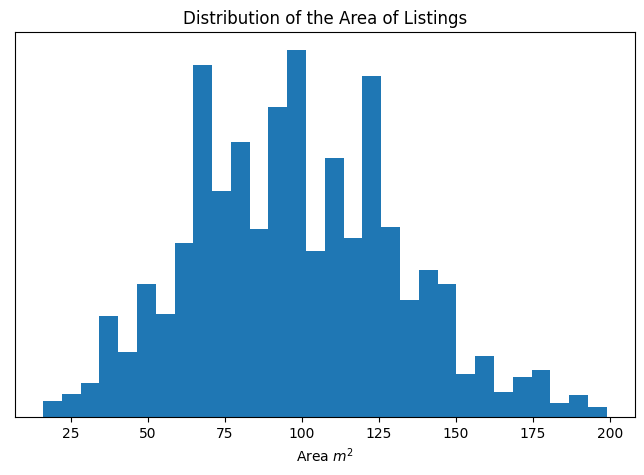

In [16]:
# display(df.neighborhood.value_counts())
display(df)
d1 = df.copy()
# d1.area = [round(area, -1) for area in df.area]
_, area_bins = pd.qcut(df.area, 10, retbins=True)
_, price_bins = pd.qcut(df.price, 10, retbins=True)
display(area_bins, price_bins)

plot = df[df.area < 200].area.hist(bins=30, figsize=(8, 5), grid=False)
plot.get_yaxis().set_visible(False)
plot.set_xlabel('Area $m^2$')
plot.set_title('Distribution of the Area of Listings')